In [112]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler #to normalize data
from os.path import exists

In [96]:
#see https://github.com/archd3sai/Predictive-Maintenance-of-Aircraft-Engine/blob/master/RUL%20Prediction%20Regression/LSTM%20RUL%20Prediction.ipynb
#dependent_var = ['RUL']
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']
    
df_train = pd.read_csv('RUL_train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

df_train = df_train.drop(cols_to_drop, axis = 1)

In [97]:
print("Predictive Maintenance techniques are used to determine the condition of an equipment to plan the maintenance/failure ahead of its time\n")
print("Classification: Predicting the failure of machine in upcoming n days\n")
print("The lengths of the run varied with a minimum run length of 128 cycles and the maximum length of 356 cycles\n")
print("RUL - remaining useful life\n\n")
print(df_train.head(1))

Predictive Maintenance techniques are used to determine the condition of an equipment to plan the maintenance/failure ahead of its time

Classification: Predicting the failure of machine in upcoming n days

The lengths of the run varied with a minimum run length of 128 cycles and the maximum length of 356 cycles

RUL - remaining useful life


   UnitNumber  Cycle  OpSet1  OpSet2  SensorMeasure2  SensorMeasure3  \
0           1      1 -0.0007 -0.0004          641.82          1589.7   

   SensorMeasure4  SensorMeasure7  SensorMeasure8  SensorMeasure9  \
0          1400.6          554.36         2388.06         9046.19   

   SensorMeasure11  SensorMeasure12  SensorMeasure13  SensorMeasure15  \
0            47.47           521.66          2388.02           8.4195   

   SensorMeasure17  SensorMeasure20  SensorMeasure21  
0              392            39.06           23.419  


In [98]:
print("Find the max cycle count for each unit\n"
     )
rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
rul.columns = ['UnitNumber', 'max']
print(rul.head(3))

df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
df_train['RUL'] = df_train['max'] - df_train['Cycle']
df_train.drop('max', axis=1, inplace=True)
print(df_train.head(3))

Find the max cycle count for each unit

   UnitNumber  max
0           1  192
1           2  287
2           3  179
   UnitNumber  Cycle  OpSet1  OpSet2  SensorMeasure2  SensorMeasure3  \
0           1      1 -0.0007 -0.0004          641.82         1589.70   
1           1      2  0.0019 -0.0003          642.15         1591.82   
2           1      3 -0.0043  0.0003          642.35         1587.99   

   SensorMeasure4  SensorMeasure7  SensorMeasure8  SensorMeasure9  \
0         1400.60          554.36         2388.06         9046.19   
1         1403.14          553.75         2388.04         9044.07   
2         1404.20          554.26         2388.08         9052.94   

   SensorMeasure11  SensorMeasure12  SensorMeasure13  SensorMeasure15  \
0            47.47           521.66          2388.02           8.4195   
1            47.49           522.28          2388.07           8.4318   
2            47.27           522.42          2388.03           8.4178   

   SensorMeasure17  Senso

In [99]:
#y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
#y_true["UnitNumber"] = y_true.index

#print(y_true)

In [106]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

X_Columns = [column for column in df_train.columns if column !="RUL"]

min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[X_Columns] = min_max_scaler.fit_transform(df_train[X_Columns])

sequence_length=50

X_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, X_Columns)) for unit in df_train['UnitNumber'].unique()))
print("X_train",X_train.shape)
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
print("y_train",y_train.shape)

X_train (15731, 50, 17)
y_train (15731,)


In [114]:
nb_features = X_train.shape[2]
nb_out = 1



model = Sequential()
model.add(LSTM(
         units=512,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(
          units=128,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 50, 512)           1085440   
                                                                 
 batch_normalization_5 (Batc  (None, 50, 512)          2048      
 hNormalization)                                                 
                                                                 
 dropout_16 (Dropout)        (None, 50, 512)           0         
                                                                 
 lstm_17 (LSTM)              (None, 128)               328192    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                      

In [115]:

print ("Train the model")
length=len(X_train)
path_to_file="C:\\Users\\dnishimoto\\python_files\\python-deep-learning-master\\lstm_aircraft_model.h5"

file_exists = exists(path_to_file)
if(file_exists):
    model.load_weights(path_to_file)
    
history=model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

model.save_weights(path_to_file)


Train the model
Epoch 1/3
443/443 [==============================] - 339s 759ms/step - loss: 5016.1572 - mse: 5016.1572 - val_loss: 6858.0068 - val_mse: 6858.0068
Epoch 2/3
443/443 [==============================] - 363s 819ms/step - loss: 1826.7635 - mse: 1826.7635 - val_loss: 2359.4226 - val_mse: 2359.4226
Epoch 3/3
443/443 [==============================] - 262s 592ms/step - loss: 952.4440 - mse: 952.4440 - val_loss: 11214.6777 - val_mse: 11214.6777


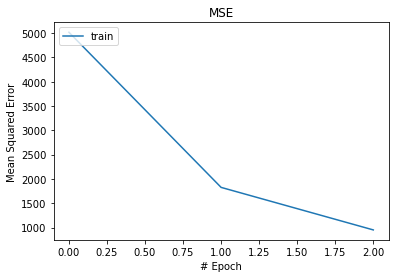

In [116]:
plt.plot(history.history['mse'])
#plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [117]:
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

79/79 [==============================] - 40s 507ms/step - loss: 8489.4307 - mse: 8489.4316
MSE: 8489.431640625


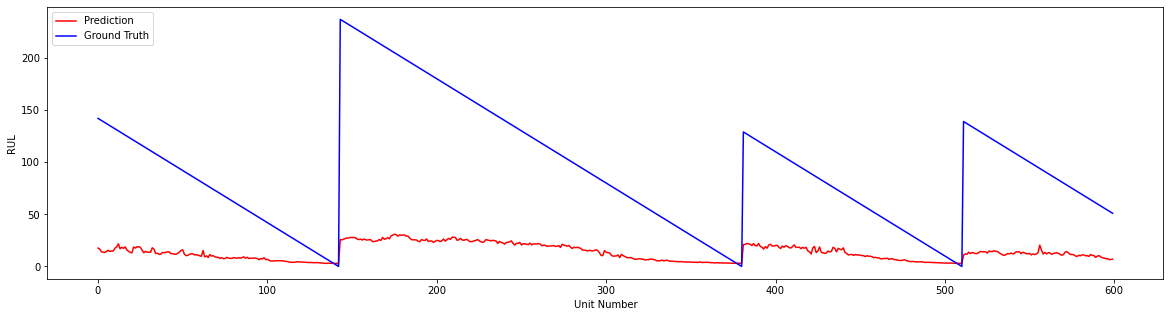

In [118]:
y_pred_test = model.predict(X_train[0:600], verbose=0)

plt.figure(figsize=(20,5))
plt.plot(y_pred_test, color='red', label='Prediction')
plt.plot(y_train[0:600], color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

In [119]:
print("done!")

done!
